In this notebook we test SBL.

In [96]:
# %% General imports
import numpy as np
import torch

# DeepMoD stuff
from multitaskpinn import DeepMoD
from multitaskpinn.model.func_approx import NN
from multitaskpinn.model.library import Library1D
from multitaskpinn.model.constraint import LeastSquares, Ridge
from multitaskpinn.model.sparse_estimators import Threshold
from multitaskpinn.training.sparsity_scheduler import TrainTestPeriodic
from multitaskpinn.utils.logger import Logger
from multitaskpinn.training.convergence import Convergence
from multitaskpinn.training import train_SBL
from sklearn.linear_model import LassoCV

from deepymod.data import Dataset
from deepymod.data.burgers import BurgersDelta
from deepymod.analysis import load_tensorboard

In [97]:
# Settings
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

device='cpu'

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Making dataset

In [10]:
# Making dataset
v = 0.25
A = 1.0

x = np.linspace(-3, 4, 40)
t = np.linspace(0.1, 5.0, 25)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(BurgersDelta, v=v, A=A)
X, y = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.1, random=True, normalize=True)
X, y = X.to(device), y.to(device)

# Running

## SBL non-differentiable

In [4]:
network = NN(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1, LassoCV(fit_intercept=False, cv=20)) # Sparse estimator 
constraint = LeastSquares()#Ridge(l=1e-3)# # How to constrain
model = DeepMoD(network, library, estimator, constraint, 12).to(device) # Putting it all in the model

sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=1000, delta=1e-6) # in terms of write iterations
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2e-3) # Defining optimizer

In [5]:
train_SBL(model, X, y, optimizer, sparsity_scheduler, exp_ID='SBL_non_diff', split=0.8, write_iterations=50, max_iterations=50000, delta=1e-3, patience=1e8) 

 49950  MSE: 2.44e-04  Reg: 1.42e-07  L1: 1.86e+00 Algorithm converged. Writing model to disk.


## SBL fully diff

In [14]:
network = NN(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1, LassoCV(fit_intercept=False, cv=2)) # Sparse estimator 
constraint = LeastSquares()#Ridge(l=1e-3)# # How to constrain
model = DeepMoD(network, library, estimator, constraint, 12).to(device) # Putting it all in the model

sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=1e8, delta=1e-6) # in terms of write iterations
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2e-3) # Defining optimizer

In [15]:
train_SBL(model, X, y, optimizer, sparsity_scheduler, exp_ID='SBL_diff_long', split=0.8, write_iterations=100, max_iterations=100000, delta=1e-3, patience=1e8) 

 99900  MSE: 2.41e-04  Reg: 3.31e-08  L1: 1.64e+00 Algorithm converged. Writing model to disk.


# Plot

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context='talk', style='white')
%config InlineBackend.figure_format = 'svg'

from natsort import natsorted

In [163]:
df = load_tensorboard('runs/Nov30_17-13-06_workstationgjSBL_diff_long/')

In [165]:
#coeff_keys = natsorted([key for key in df.keys() if key[:8] == 'unscaled'])
#coeff_keys = natsorted([key for key in df.keys() if key[:8] == 'unscaled'])

alpha_keys = natsorted([key for key in df.keys() if key.find('alpha') != -1])

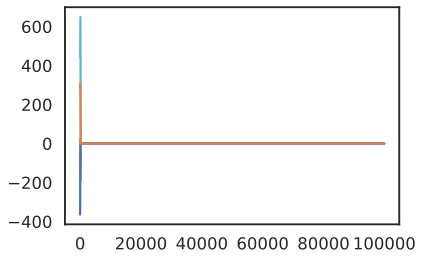

In [166]:
plt.plot(df.index, df[coeff_keys])
#plt.ylim([-0.8, 0.2])

In [173]:
import matplotlib

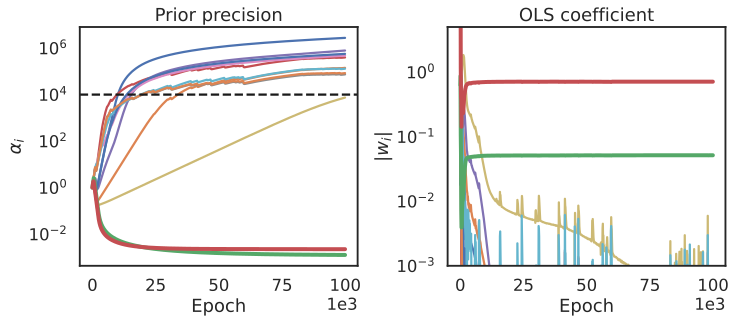

In [186]:
cm = 1/2.54  # centimeters in inches
matplotlib.rcParams.update({'font.size': 20})


fig, axes = plt.subplots(ncols=2, figsize=(25.7*cm, 11.1*cm), constrained_layout=True)

ax = axes[0]
ax.plot(df.index, df[alpha_keys])
ax.plot(df.index, df[alpha_keys[2]], lw=4)
ax.plot(df.index, df[alpha_keys[5]], lw=4)

#ax.set_xlim([0, 1e5])
ax.set_yscale('log')
ax.axhline(1e4, color='k', linestyle='--')
ax.set_xlabel('Epoch')
ax.set_ylabel(r'$\alpha_i$')
ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
ax.set_title('Prior precision')

ax=axes[1]
ax.semilogy(df.index, np.abs(df[coeff_keys]))
ax.semilogy(df.index, np.abs(df[coeff_keys[2]]), lw=4)
ax.semilogy(df.index, np.abs(df[coeff_keys[5]]), lw=4)

ax.set_ylim([1e-3, 5e0])
ax.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
ax.set_xlabel('Epoch')
ax.set_ylabel(r'$|w_i|$')
ax.set_title('OLS coefficient')

plt.savefig('sbl.svg')

# Plotting multiple

In [114]:
from os import listdir
import os
import pandas as pd

In [106]:
file_names = 

In [124]:
def combine_runs():
    ''' Loads all tensorboard files in a directory into a single frame.
    Usefull for when you have multiple runs and possibly multiple types to compare.
    Assumes name of folders are [type]_run_[run_idx]'''
    log_locs = natsorted([key for key in listdir('runs') if ((key.find('SBL_diff_run') != -1) and (key[-3:] != '.pt'))])
    logs = []
    for run in log_locs:
        df = load_tensorboard(os.path.join('runs/', run)) # load tb file to pandas
        df['type'] = run.split('_')[-3] # get type of run
        df['run'] = int(run.split('_')[-1]) # get unique run number if multiple runs
        df = df.reset_index().rename(columns={'index': 'epoch'})
        logs.append(df)
    return pd.concat(logs, axis=0, ignore_index=True)

In [125]:
df = combine_runs()

In [127]:
df.query('run ==1')

,epoch,loss_loss,remaining_MSE_test,remaining_p_MSE,remaining_p_reg,remaining_tau,remaining_beta_,remaining_alpha_val_9,unscaled_coeffs_output_0_coeff_6,remaining_mn_val_3,...,unscaled_coeffs_output_0_coeff_7,estimator_coeffs_output_0_coeff_10,estimator_coeffs_output_0_coeff_5,remaining_mn_val_8,unscaled_coeffs_output_0_coeff_9,unscaled_coeffs_output_0_coeff_8,remaining_mn_val_7,estimator_coeffs_output_0_coeff_8,type,run
500,0,-2080.096191,0.028275,1029.384277,2886.436279,37.662926,37.662926,1.000000,-144.158218,-0.013097,...,6.461214e+01,0.000000,-0.522960,0.129185,-486.139496,-13.692737,0.017400,0.442561,diff,1
501,100,-2550.005127,0.012766,1271.477539,3034.785156,42.749866,46.001637,1.214150,-2.700450,0.198105,...,-3.191851e-02,-0.608846,-0.222712,-0.293598,0.728692,-5.908050,-0.099771,-6.087943,diff,1
502,200,-2862.502930,0.009662,1344.742920,3194.627930,51.557663,56.186069,1.476908,0.118316,0.299164,...,2.176630e-02,0.199595,-1.150487,-0.140360,4.840854,2.069155,-0.059692,0.935302,diff,1
503,300,-3224.085449,0.004352,1474.988647,3346.668213,62.703320,68.624825,1.781028,0.128995,-0.037556,...,-9.369195e-03,-0.851576,0.000000,-0.818136,-0.038065,-0.691432,-0.030613,-0.504095,diff,1
504,400,-3551.753418,0.002658,1575.357300,3494.780762,76.350113,83.817337,2.120287,0.004195,0.093089,...,-1.546061e-03,-0.312155,-0.129392,-1.794595,-0.032817,-1.135965,-0.068101,-0.757604,diff,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,49500,-10714.064453,0.000284,2922.985596,8148.890137,4053.441406,29587.488281,3494.891602,-0.000006,-0.000051,...,1.378357e-07,0.000000,-0.611545,-0.609237,0.000206,-0.134827,-0.000886,0.000000,diff,1
996,49600,-10714.112305,0.000284,2922.997070,8149.076172,4053.561279,29593.132812,3511.261475,-0.000006,-0.000060,...,-4.004687e-08,0.000000,-0.612015,-0.604752,0.000202,-0.133823,-0.001425,0.000000,diff,1
997,49700,-10714.188477,0.000284,2923.010742,8149.270996,4053.646484,29598.101562,3527.708008,-0.000003,-0.000024,...,5.326001e-07,0.000000,-0.612478,-0.601739,0.000247,-0.133204,-0.000486,0.000000,diff,1
998,49800,-10714.253906,0.000284,2923.023682,8149.397949,4053.797119,29600.923828,3544.231445,-0.000004,-0.000037,...,2.497109e-07,0.000000,-0.612963,-0.597714,0.000228,-0.132288,-0.000814,0.000000,diff,1


In [128]:
coeff_keys = natsorted([key for key in df.keys() if key[:8] == 'unscaled'])
alpha_keys = natsorted([key for key in df.keys() if key.find('alpha') != -1])

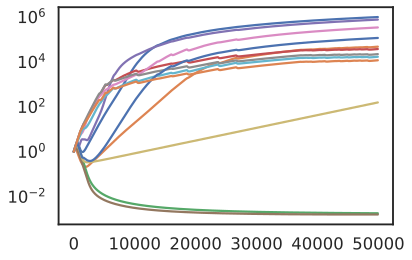

In [131]:
plt.plot(df.query('run == 0').epoch, df.query('run == 0')[alpha_keys])
plt.yscale('log')

In [152]:
mean_alpha = np.mean(np.log(np.stack([df[alpha_keys] for _, df in df.groupby('run')], axis=-1)), axis=-1)
std_alpha = np.std(np.log(np.stack([df[alpha_keys] for _, df in df.groupby('run')], axis=-1)), axis=-1)

In [158]:
(mean_alpha[:, idx] - std_alpha[:, idx]).shape

(500,)

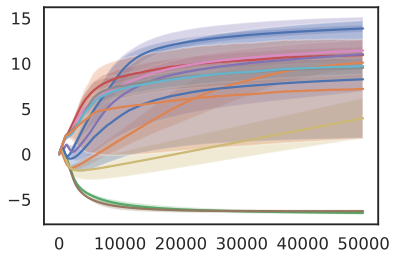

In [161]:
for idx in np.arange(mean_alpha.shape[1]):
    plt.plot(df.query('run==0').epoch, mean_alpha[:, idx])
    plt.fill_between(df.query('run==0').epoch, mean_alpha[:, idx] - std_alpha[:, idx], mean_alpha[:, idx] + std_alpha[:, idx], alpha=0.3)

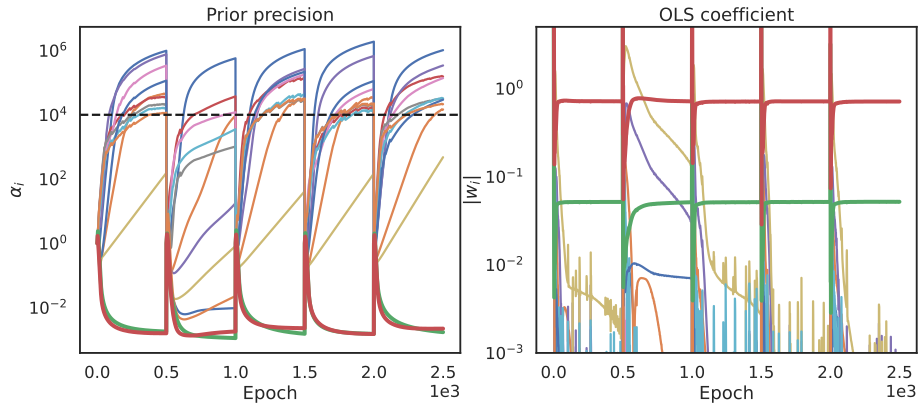

In [129]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(df.index, df[alpha_keys])
plt.plot(df.index, df[alpha_keys[2]], lw=4)
plt.plot(df.index, df[alpha_keys[5]], lw=4)
plt.yscale('log')
plt.axhline(1e4, color='k', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel(r'$\alpha_i$')
plt.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
plt.title('Prior precision')

plt.subplot(122)
plt.semilogy(df.index, np.abs(df[coeff_keys]))
plt.semilogy(df.index, np.abs(df[coeff_keys[2]]), lw=4)
plt.semilogy(df.index, np.abs(df[coeff_keys[5]]), lw=4)
plt.ylim([1e-3, 5e0])
plt.ticklabel_format(axis='x', style='sci', scilimits=[3, 3])
plt.xlabel('Epoch')
plt.ylabel(r'$|w_i|$')
plt.title('OLS coefficient')

plt.savefig('sbl.pdf')